In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

100%|██████████| 172k/172k [00:00<00:00, 237kB/s]

Extracting files...
Path to dataset files: C:\Users\panka\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [3]:
# Install necessary libraries if they are not already installed
!pip install pandas scikit-learn matplotlib seaborn xgboost optuna openpyxl

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    roc_auc_score
)
import xgboost as xgb
import optuna
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')

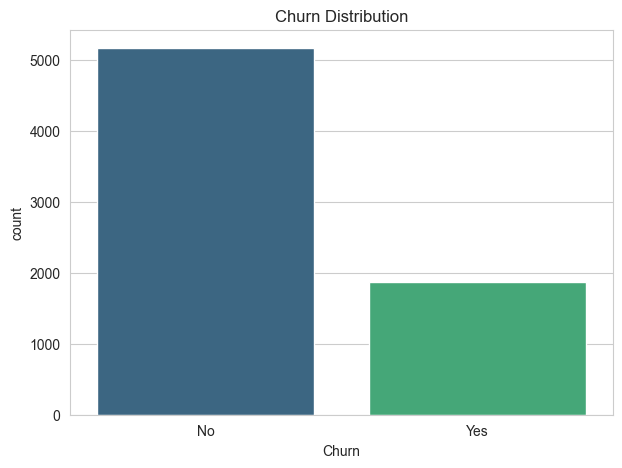

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


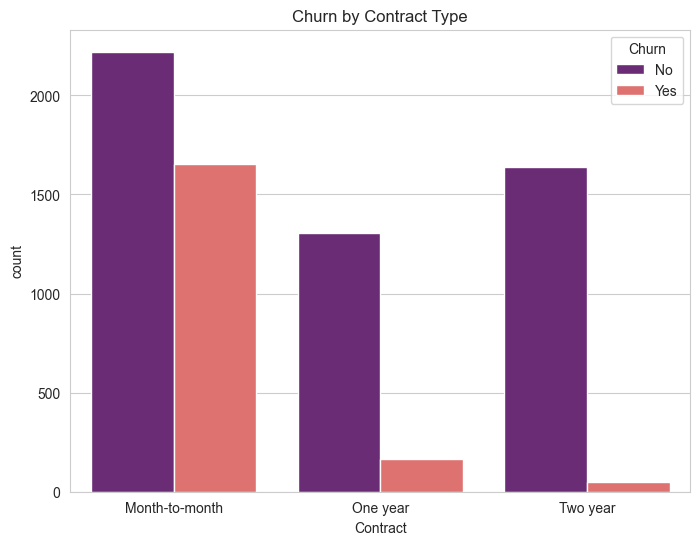

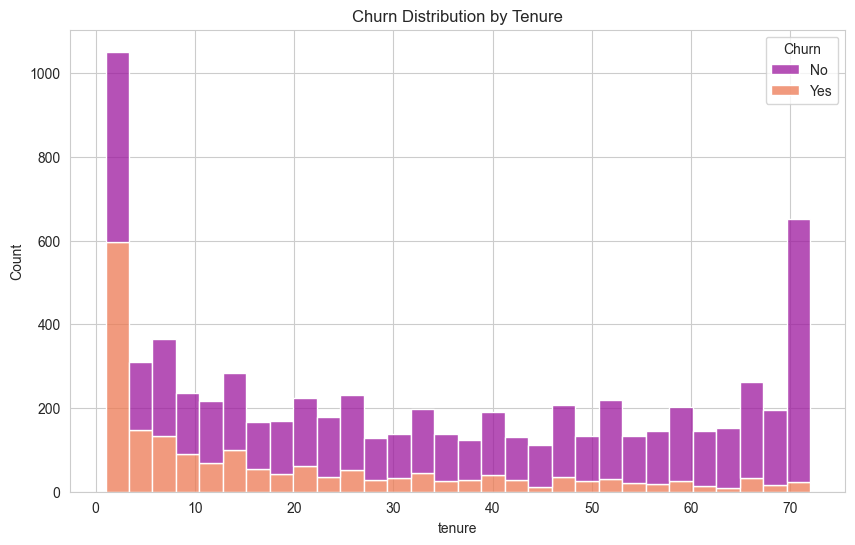

In [7]:
# Load the dataset from a public URL for reproducibility
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# --- Data Cleaning ---
# 'TotalCharges' has spaces for new customers. Convert to numeric, coercing errors, then fill NaNs.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True) # Drop the few rows where this is an issue

# --- EDA Visualization ---
# 1. Churn Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Churn Distribution')
plt.show()
print(df['Churn'].value_counts(normalize=True))

# 2. Churn vs. Contract Type
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='magma')
plt.title('Churn by Contract Type')
plt.show()

# 3. Churn vs. Tenure
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, palette='plasma')
plt.title('Churn Distribution by Tenure')
plt.show()

In [6]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [8]:
# --- Feature Engineering ---
df_feat = df.drop('customerID', axis=1).copy()

# 1. Tenure Groups
df_feat['tenure_group'] = pd.cut(df_feat['tenure'], bins=[0, 12, 24, 48, 60, 72],
                                 labels=['0-12M', '13-24M', '25-48M', '49-60M', '61-72M'], include_lowest=True)

# 2. Number of additional services
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_feat['services_count'] = df_feat[service_cols].apply(lambda row: sum(x == 'Yes' for x in row), axis=1)

# --- Re-run Preprocessing on the Feature-Engineered DataFrame ---
le = LabelEncoder()
df_feat['Churn'] = le.fit_transform(df_feat['Churn']) # Encode target variable

# *** FIX APPLIED HERE ***
# 'Churn' is now numeric, so it will not be in the list of 'object' or 'category' dtypes.
# We no longer need to .drop() it from the categorical columns list.
categorical_cols_feat = df_feat.select_dtypes(include=['object', 'category']).columns
numerical_cols_feat = df_feat.select_dtypes(include=np.number).columns.drop('Churn')

# One-hot encode the categorical features
df_processed_feat = pd.get_dummies(df_feat, columns=categorical_cols_feat, drop_first=True)

# Separate features (X) and target (y)
X = df_processed_feat.drop('Churn', axis=1)
y = df_processed_feat['Churn']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols_feat] = scaler.fit_transform(X[numerical_cols_feat])

print("\nShape of final feature set:", X.shape)

# Split data into training and testing sets, stratified by 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Shape of final feature set: (7032, 35)


In [10]:
# --- Bayesian Optimization with Optuna ---
def objective(trial):
    # Calculate scale_pos_weight to handle class imbalance
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr', # Optimize for Area Under Precision-Recall Curve
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        preds_proba = model.predict_proba(X_val_fold)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val_fold, preds_proba)
        auc_pr_score = auc(recall, precision)
        scores.append(auc_pr_score)

    return np.mean(scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', study_name='XGBoost Churn Tuning')
study.optimize(objective, n_trials=50, timeout=600)

# --- Train the Final Model with Best Hyperparameters ---
best_params = study.best_params
best_params['random_state'] = 42
best_params['scale_pos_weight'] = y_train.value_counts()[0] / y_train.value_counts()[1]

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train, verbose=False)

print("\nBest hyperparameters found by Optuna:")
print(study.best_params)

[I 2025-06-29 11:48:39,288] A new study created in memory with name: XGBoost Churn Tuning
[I 2025-06-29 11:48:46,760] Trial 0 finished with value: 0.6569723577299698 and parameters: {'n_estimators': 829, 'max_depth': 6, 'learning_rate': 0.011947414212464206, 'subsample': 0.7296367868091045, 'colsample_bytree': 0.6204243253557626, 'gamma': 0.026412548603493926}. Best is trial 0 with value: 0.6569723577299698.
[I 2025-06-29 11:48:52,440] Trial 1 finished with value: 0.6644263009479088 and parameters: {'n_estimators': 926, 'max_depth': 4, 'learning_rate': 0.01366589062809689, 'subsample': 0.6399794758159282, 'colsample_bytree': 0.6080626135394119, 'gamma': 2.813896333735822e-07}. Best is trial 1 with value: 0.6644263009479088.
[I 2025-06-29 11:49:12,098] Trial 2 finished with value: 0.644089011566183 and parameters: {'n_estimators': 1081, 'max_depth': 7, 'learning_rate': 0.015183252272066655, 'subsample': 0.902390675250664, 'colsample_bytree': 0.7044431985149964, 'gamma': 8.76381839486865


Best hyperparameters found by Optuna:
{'n_estimators': 541, 'max_depth': 3, 'learning_rate': 0.013123183060130295, 'subsample': 0.6595408590896096, 'colsample_bytree': 0.8352643448154731, 'gamma': 0.00254067240750609}



--- Model Evaluation on Test Set ---
Area Under Precision-Recall Curve (AUC-PR): 0.6580


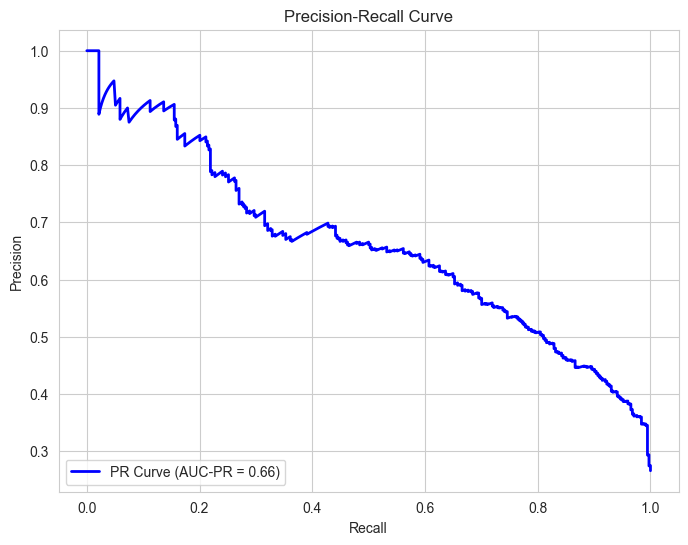


--- Lift Chart Analysis ---


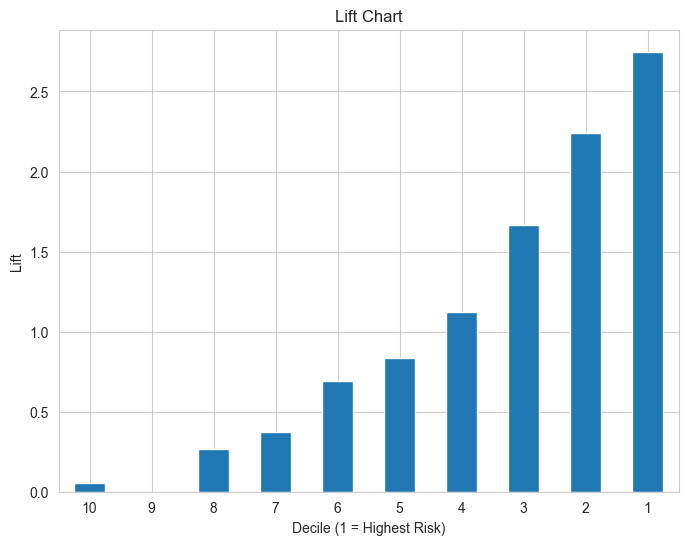

        count  churners  churn_rate      lift
decile                                       
10        141         2    0.014184  0.053362
9         141         0    0.000000  0.000000
8         140        10    0.071429  0.268717
7         141        14    0.099291  0.373535
6         141        26    0.184397  0.693708
5         140        31    0.221429  0.833021
4         141        42    0.297872  1.120605
3         140        62    0.442857  1.666043
2         141        84    0.595745  2.241211
1         141       103    0.730496  2.748151

--- CLTV Impact Analysis ---
By targeting the top 10% highest-risk customers identified by the model:
We capture 103 actual churners.
The potential annual profit at risk from this group is: $19,402.68
This figure represents the value we can try to save with a targeted retention campaign.

--- Detailed Performance Record ---

Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.91      0.70      0.7

In [11]:
# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# --- Advanced Metrics ---
print("\n--- Model Evaluation on Test Set ---")

# 1. Precision-Recall Curve (essential for imbalanced datasets)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC-PR = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 2. Lift Chart
def plot_lift_chart(y_true, y_probas):
    results = pd.DataFrame({'true_label': y_true, 'probability': y_probas})
    results = results.sort_values(by='probability', ascending=False)
    results['decile'] = pd.qcut(results['probability'], 10, labels=np.arange(10, 0, -1))
    
    lift_data = results.groupby('decile')['true_label'].agg(['count', 'sum'])
    lift_data.rename(columns={'sum': 'churners'}, inplace=True)
    lift_data['churn_rate'] = lift_data['churners'] / lift_data['count']
    overall_churn_rate = lift_data['churners'].sum() / lift_data['count'].sum()
    lift_data['lift'] = lift_data['churn_rate'] / overall_churn_rate
    
    plt.figure(figsize=(8, 6))
    lift_data['lift'].plot(kind='bar')
    plt.title('Lift Chart')
    plt.xlabel('Decile (1 = Highest Risk)')
    plt.ylabel('Lift')
    plt.xticks(rotation=0)
    plt.show()
    return lift_data

print("\n--- Lift Chart Analysis ---")
lift_df = plot_lift_chart(y_test, y_pred_proba)
print(lift_df)

# 3. Customer Lifetime Value (CLTV) Impact Analysis (Conceptual)
def cltv_impact_analysis(y_true, y_probas, monthly_charges_test, tenure_test):
    # Simplified CLTV: (Monthly Charge * 12) * Avg. Customer Lifespan * Profit Margin
    # Let's assume a profit margin of 20%
    profit_margin = 0.2
    
    # Combine results
    results = pd.DataFrame({
        'true_label': y_true,
        'probability': y_probas,
        'monthly_charge': monthly_charges_test,
        'tenure': tenure_test
    })
    
    # Simple CLTV proxy: what we stand to lose in the next 12 months from this customer
    results['potential_annual_loss'] = results['monthly_charge'] * 12 * profit_margin
    results = results.sort_values(by='probability', ascending=False)
    
    # Focus on the top 10% of at-risk customers
    top_10_percent = results.head(int(len(results) * 0.1))
    churners_in_top_10 = top_10_percent[top_10_percent['true_label'] == 1]
    
    total_potential_loss_in_group = churners_in_top_10['potential_annual_loss'].sum()
    
    print("\n--- CLTV Impact Analysis ---")
    print(f"By targeting the top 10% highest-risk customers identified by the model:")
    print(f"We capture {len(churners_in_top_10)} actual churners.")
    print(f"The potential annual profit at risk from this group is: ${total_potential_loss_in_group:,.2f}")
    print("This figure represents the value we can try to save with a targeted retention campaign.")

# Get original MonthlyCharges and tenure for the test set for CLTV analysis
X_test_orig_scaled = X_test[numerical_cols_feat]
X_test_orig_unscaled = scaler.inverse_transform(X_test_orig_scaled)
monthly_charges_test = X_test_orig_unscaled[:, numerical_cols_feat.tolist().index('MonthlyCharges')]
tenure_test = X_test_orig_unscaled[:, numerical_cols_feat.tolist().index('tenure')]

cltv_impact_analysis(y_test, y_pred_proba, monthly_charges_test, tenure_test)

# 4. Final Performance Report
print("\n--- Detailed Performance Record ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn']))

In [12]:
# Save the final model, scaler, and model columns for the API
joblib.dump(final_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'model_columns.pkl')
joblib.dump(numerical_cols_feat.tolist(), 'numerical_cols.pkl')

['numerical_cols.pkl']